<a href="https://colab.research.google.com/github/saGit1990/awesome-generative-ai-guide/blob/main/Aspect_Text_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# upload files in colab
# c0fcef2410701a28c0c3b5bf5021bdf4ae72fb36
from google.colab import files
uploaded = files.upload()

Saving Restaurants_Train_v2 2.xml to Restaurants_Train_v2 2.xml


In [2]:
import xml.etree.ElementTree as ET
import pandas as pd

# Load XML
with open('Restaurants_Train_v2 2.xml', 'r', encoding = 'utf-8') as file:
  tree = ET.parse(file)
  root = tree.getroot()

In [3]:
#!pip install numpy
import numpy as np
np.__version__

'2.0.2'

In [4]:
from os import sendfile

data = []
for idx, sentence in enumerate(root.findall('sentence')):
  #if idx == 0:
  send_id = sentence.attrib['id']
  text = sentence.find('text').text

  aspect_terms = []
  aspect_categories = []

  aspect_terms_elem = sentence.find('aspectTerms')
  if aspect_terms_elem is not None:
    for aspect_term in aspect_terms_elem.findall('aspectTerm'):
      term = aspect_term.attrib.get('term')
      polarity = aspect_term.attrib.get('polarity')
      from_idx = int(aspect_term.attrib.get('from'))
      to_idx = int(aspect_term.attrib.get('to'))

      aspect_terms.append({
          'term': term ,
          'polarity': polarity,
          'from': from_idx ,
          'to': to_idx
      })

  aspect_cats_elem = sentence.find('aspectCategories')
  if aspect_cats_elem is not None:
    for aspect_cat in aspect_cats_elem.findall('aspectCategory'):
      category = aspect_cat.attrib.get('category')
      polarity = aspect_cat.attrib.get('polarity')
      aspect_categories.append({
          'category': category ,
          'polarity': polarity
      })

  data.append({
      "id":send_id,
      "text":text ,
      "aspect_terms": aspect_terms,
      "aspect_categories": aspect_categories
  })

In [5]:
df = pd.DataFrame(data)
df.iloc[0,:][2]

<ipython-input-5-6c81edeee736>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.iloc[0,:][2]


[{'term': 'staff', 'polarity': 'negative', 'from': 8, 'to': 13}]

In [6]:
# aspect text extrcation - ner style bio tagging
'''
  we wil tokenize each sentence and label token with BIO tags
  B-ASP ; Beggining of aspect Term
  I-ASP: inside aspect term
  O - outside aspect term
'''
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

def tokenize_with_offset(text):
  words = word_tokenize(text)
  offsets = []
  idx = 0
  for word in words:
    start = text.find(word, idx)
    end = start + len(word)
    offsets.append((word, start ,end))
    idx = end
  return offsets


bio_data = []

for _, row in df.iterrows():
  text = row['text']
  aspect_terms = row['aspect_terms']
  term_span = [ (t['from'], t['to']) for t in aspect_terms]

  tokens_with_offsets = tokenize_with_offset(text)
  labels = []

  for token, start, end in tokens_with_offsets:
    label = 'O'
    for asp_start, asp_end in term_span:
      if asp_start <= start and end <= asp_end: # Adjusted logic to check if the token is fully within an aspect term span
        if asp_start == start:
            label = 'B-ASP'
        else:
            label = 'I-ASP'
        break
      # Add a check for partial overlap where the token starts within an aspect term but ends outside
      elif asp_start < start < asp_end and end > asp_end:
           label = 'I-ASP'
           break
    labels.append((token, label))


  bio_data.append({
      'id':row['id'],
      'tokens': [t for t, _ in labels],
      'labels' : [l for _, l in labels]
  })

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [7]:
bio_data[0]

{'id': '3121',
 'tokens': ['But', 'the', 'staff', 'was', 'so', 'horrible', 'to', 'us', '.'],
 'labels': ['O', 'O', 'B-ASP', 'O', 'O', 'O', 'O', 'O', 'O']}

In [8]:
# aspect cateogry classification - data preparation

category_data = []

for _ , row in df.iterrows():
  text = row['text']
  for cat in row['aspect_categories']:
    categories = cat['category']
    polarity = cat['polarity']
    category_data.append({
        'id': row['id'],
        'text': text,
        'category': categories,
        'polarity': polarity
    })

df_cat = pd.DataFrame(category_data)
df_cat.head()

,id,text,category,polarity
0,3121,But the staff was so horrible to us.,service,negative
1,2777,"To be completely fair, the only redeeming fact...",food,positive
2,2777,"To be completely fair, the only redeeming fact...",anecdotes/miscellaneous,negative
3,1634,"The food is uniformly exceptional, with a very...",food,positive
4,2534,Where Gabriela personaly greets you and recomm...,service,positive


In [9]:
# prepare aspect term sentiment dataset

aspect_sentiment_data = []

for _ , row in df.iterrows():
  text = row['text']
  for aspect in row.aspect_terms:
    aspect_sentiment_data.append({
        'id': row['id'],
        'text': text,
        'aspect': aspect['term'] ,
        'from': aspect['from'],
        'to': aspect['to'],
        'polarity': aspect['polarity']
    })

In [10]:
df_aspect_polarity = pd.DataFrame(aspect_sentiment_data)
df_aspect_polarity.sample()

,id,text,aspect,from,to,polarity
1707,951,One would think we'd get an apology or complim...,drinks,53,59,neutral


In [13]:
!pip install seqeval
# c0fcef2410701a28c0c3b5bf5021bdf4ae72fb36

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=b6b8c937bda7e85119492cd78e9a1949d9c2aa6ae1eb026e388d7340319e2e78
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [14]:
#!pip install --upgrade datasets

In [42]:
# train a transformer for aspect term extraction (BIO Tagging)
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    DataCollatorForSeq2Seq,DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

import torch
import numpy as np
from seqeval.metrics import classification_report, f1_score

In [12]:
label_lst = ['O','B-ASP','I-ASP']

label2id = {l:i for i , l in enumerate(label_lst)}
id2label = {i:l for l,i in label2id.items()}

for row in bio_data:
  row['label_ids'] = [label2id[l] for l in row['labels']]

dataset = Dataset.from_list(bio_data)
dataset

Dataset({
    features: ['id', 'tokens', 'labels', 'label_ids'],
    num_rows: 3041
})

In [13]:
bio_data_df = pd.DataFrame(bio_data)
i_asp_rows = bio_data_df[bio_data_df['labels'].apply(lambda x: 'I-ASP' in x)]
i_asp_rows.iloc[5,:]

,31
id,2227
tokens,"[My, suggestion, is, to, eat, family, style, b..."
labels,"[O, O, O, O, B-ASP, I-ASP, I-ASP, O, O, O, O, ..."
label_ids,"[0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

def tokenize_and_align_labels(example):
  tokenized = tokenizer(
      example['tokens'],
      is_split_into_words=True,
      truncation=True,
      padding='max_length',
      max_length=128
  )

  labels = []
  word_ids = tokenized.word_ids()
  prev_word_id = None

  for word_id in word_ids:
    if word_id is None:
      labels.append(-100)
    elif word_id != prev_word_id:
      labels.append(example['label_ids'][word_id])
    else:
      labels.append(example['label_ids'][word_id])
    prev_word_id = word_id

  tokenized['labels'] = labels
  return tokenized

encoded_dataset = dataset.map(tokenize_and_align_labels, batched = False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/3041 [00:00<?, ? examples/s]

In [15]:
encoded_dataset = encoded_dataset.remove_columns(['id', 'tokens', 'label_ids'])
encoded_dataset[0].keys()

dict_keys(['labels', 'input_ids', 'token_type_ids', 'attention_mask'])

In [16]:
# MODEL & TRAINING
model = AutoModelForTokenClassification.from_pretrained(
    'bert-base-cased',
    num_labels = len(label_lst),
    id2label = id2label,
    label2id = label2id
)

# Split aspect dataset into train and eval
train_size_cat = int(0.8 * len(encoded_dataset))
eval_size_cat = len(encoded_dataset) - train_size_cat
train_dataset_cat, eval_dataset_cat = torch.utils.data.random_split(encoded_dataset, [train_size_cat, eval_size_cat])

data_collector = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Define compute_metrics function to handle list of lists format
def compute_metrics(p):
    predictions, labels = p
    # Get the predicted labels by taking the argmax
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (padding)
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Compute F1 score using seqeval
    return {
        "f1": f1_score(true_labels, true_predictions)
    }

training_args = TrainingArguments(
    output_dir = './aspect_term_model',
    eval_strategy  = 'epoch',
    logging_dir = './logs',
    num_train_epochs = 3,
    weight_decay = 0.01,
    save_strategy = 'epoch'
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset_cat,
    eval_dataset = eval_dataset_cat,
    tokenizer = tokenizer,
    data_collator = data_collector,
    compute_metrics = compute_metrics
)

trainer.train()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-86c4f543ce5c>:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: suelahmed (suelahmed-self) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1
1,No log,0.097094,0.811350
2,0.111900,0.114577,0.827621
3,0.111900,0.137985,0.839823


TrainOutput(global_step=912, training_loss=0.07343516956295884, metrics={'train_runtime': 229.7555, 'train_samples_per_second': 31.755, 'train_steps_per_second': 3.969, 'total_flos': 476609593245696.0, 'train_loss': 0.07343516956295884, 'epoch': 3.0})

ASPECT CATEGORY CLASSIFICATION

In [17]:
#!pip install --upgrade datasets
from datasets import Dataset

In [18]:
# aspect category classification
hf_cat = df_cat.copy()
hf_cat['input_text'] = hf_cat.apply(lambda x: f'{x.text} [CATEGORY] {x.category}', axis = 1)
hf_cat.sample()

,id,text,category,polarity,input_text
3000,1977,Forget the rush and the wait and the noise (wh...,ambience,conflict,Forget the rush and the wait and the noise (wh...


In [19]:
category_label_map = {
    'ambience': 0,
    'anecdotes/miscellaneous': 1,
    'food': 2,
    'price': 3,
    'service':4
}

hf_cat['label'] = hf_cat['category'].map(category_label_map)

hf_cat = hf_cat[['input_text', 'label']]
hf_cat.iloc[3000,:]

,3000
input_text,Forget the rush and the wait and the noise (wh...
label,0


In [20]:
hf_cat_dataset = Dataset.from_pandas(hf_cat)
hf_cat_dataset[0]

{'input_text': 'But the staff was so horrible to us. [CATEGORY] service',
 'label': 4}

In [21]:
category_id2label = {v: k for k, v in category_label_map.items()}
category_label2id = category_label_map

In [22]:
category_id2label

{0: 'ambience',
 1: 'anecdotes/miscellaneous',
 2: 'food',
 3: 'price',
 4: 'service'}

In [23]:
category_label2id

{'ambience': 0,
 'anecdotes/miscellaneous': 1,
 'food': 2,
 'price': 3,
 'service': 4}

In [24]:
hf_cat_dataset[1000]

{'input_text': 'I was pretty much full after our fondue appetizer. [CATEGORY] food',
 'label': 2}

In [25]:
# tokenize
cat_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_cat(example):
  return cat_tokenizer(example['input_text'], truncation = True, padding='max_length', max_length = 128)

tokenize_dataset = hf_cat_dataset.map(tokenize_cat)
tokenize_dataset = tokenize_dataset.remove_columns(['input_text'])
tokenize_dataset.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'token_type_ids', 'label']
)
tokenize_dataset.set_format('torch')

Map:   0%|          | 0/3713 [00:00<?, ? examples/s]

In [26]:
tokenize_dataset

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3713
})

In [59]:
# Split aspect category classification dataset into train and eval
train_size_cat = int(0.8 * len(tokenize_dataset))
eval_size_cat = len(tokenize_dataset) - train_size_cat
train_dataset_cat, eval_dataset_cat = torch.utils.data.random_split(tokenize_dataset, [train_size_cat, eval_size_cat])


# MODEL & TRAINING C

'''
  Using Trainer for aspect category classification
'''

model_cat = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = len(category_label2id),
    id2label = category_id2label,
    label2id = category_label2id
)
def compute_metrics(p):
    predictions, labels = p

    predictions = np.argmax(predictions, axis=1)
    from sklearn.metrics import f1_score, accuracy_score

    f1 = f1_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)

    return {
        "f1": f1,
        "accuracy": accuracy
    }


training_args_cat = TrainingArguments(
    output_dir = './category_model_trainer',
    eval_strategy  = 'epoch',
    per_device_train_batch_size=8,
    num_train_epochs = 3, # Increased epochs for better training
    weight_decay = 0.01
)

trainer_cat = Trainer(
    model = model_cat,
    args = training_args_cat,
    train_dataset = train_dataset_cat,
    eval_dataset = eval_dataset_cat,
    tokenizer = cat_tokenizer,
    # data_collator is not strictly needed for SequenceClassification when padding is handled by tokenizer
    data_collator=DataCollatorWithPadding(tokenizer=cat_tokenizer), # Optional: if you want dynamic padding
    compute_metrics = compute_metrics
)

trainer_cat.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-59-210355ac53f5>:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_cat = Trainer(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.000438,1.000000,1.000000
2,0.071300,0.000220,1.000000,1.000000
3,0.000300,0.000181,1.000000,1.000000


TrainOutput(global_step=1116, training_loss=0.03210061640682293, metrics={'train_runtime': 266.6516, 'train_samples_per_second': 33.414, 'train_steps_per_second': 4.185, 'total_flos': 586095662338560.0, 'train_loss': 0.03210061640682293, 'epoch': 3.0})

In [31]:
# aspend polarity based sentiment analysis
df_polarity  = df_aspect_polarity[['text','aspect','polarity']].copy()
df_polarity.head()

,text,aspect,polarity
0,But the staff was so horrible to us.,staff,negative
1,"To be completely fair, the only redeeming fact...",food,positive
2,"The food is uniformly exceptional, with a very...",food,positive
3,"The food is uniformly exceptional, with a very...",kitchen,positive
4,"The food is uniformly exceptional, with a very...",menu,neutral


In [32]:
df_polarity['input_text'] = df_polarity.apply(lambda x: f"{x['text']} [ASP] {x['aspect']}", axis = 1)
df_polarity.sample()

,text,aspect,polarity,input_text
625,The waitress was very patient with us and the ...,food,positive,The waitress was very patient with us and the ...


In [33]:
df_polarity.polarity.unique()

array(['negative', 'positive', 'neutral', 'conflict'], dtype=object)

In [34]:
polarity_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2,
    'conflict': 3
}

In [35]:
df_polarity['label'] = df_polarity.polarity.map(polarity_map)

# Create id2label mapping (string labels to integer IDs)
pol_label2id = polarity_map

# Create label2id mapping (integer IDs to string labels)
pol_id2label = {v: k for k, v in polarity_map.items()}

In [36]:
dataset_pol = Dataset.from_pandas(df_polarity[[
  'input_text',
  'label'
]])

In [39]:
pol_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_pol(example):
  return pol_tokenizer(example['input_text'], truncation = True, padding='max_length', max_length = 128)

pol_tokenized = dataset_pol.map(tokenize_pol, batched = False)
pol_tokenized = pol_tokenized.remove_columns(['input_text'])
pol_tokenized.set_format('torch')

Map:   0%|          | 0/3693 [00:00<?, ? examples/s]

In [40]:
pol_model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = len(pol_label2id),
    label2id=pol_label2id,
    id2label = pol_id2label
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
# Split aspect category classification dataset into train and eval
train_size_cat = int(0.8 * len(pol_tokenized))
eval_size_cat = len(pol_tokenized) - train_size_cat
train_dataset_cat, eval_dataset_cat = torch.utils.data.random_split(pol_tokenized, [train_size_cat, eval_size_cat])


# MODEL & TRAINING
def compute_metrics(p):
    predictions, labels = p

    predictions = np.argmax(predictions, axis=1)
    from sklearn.metrics import f1_score, accuracy_score

    f1 = f1_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)

    return {
        "f1": f1,
        "accuracy": accuracy
    }

'''
  Using Trainer for aspect polarity classification
'''
training_args_cat = TrainingArguments(
    output_dir = './polarity_model_trainer',
    eval_strategy  = 'epoch',
    per_device_train_batch_size=8,
    num_train_epochs = 3, # Increased epochs for better training
    weight_decay = 0.01
)

trainer_cat = Trainer(
    model = pol_model,
    args = training_args_cat,
    train_dataset = train_dataset_cat,
    eval_dataset = eval_dataset_cat,
    tokenizer = pol_tokenizer,
    # data_collator is not strictly needed for SequenceClassification when padding is handled by tokenizer
    data_collator=DataCollatorWithPadding(tokenizer=pol_tokenizer),
    compute_metrics = compute_metrics
)

trainer_cat.train()

<ipython-input-48-5db3312aaddd>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_cat = Trainer(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.423940,0.903968,0.905277
2,0.224300,0.474816,0.897200,0.898512
3,0.150300,0.480957,0.907043,0.906631


TrainOutput(global_step=1110, training_loss=0.1780812203347146, metrics={'train_runtime': 265.7787, 'train_samples_per_second': 33.344, 'train_steps_per_second': 4.176, 'total_flos': 582933010802688.0, 'train_loss': 0.1780812203347146, 'epoch': 3.0})

Complete pipeline
1. Aspect Term Extraction: Goal is to extract aspect terms in sentence
  - BERT-based Token Classification model (like NER BIO tags)
  - input : 'the staff was rude and the food was bad."
  - output : term:'staff', 'from':4, 'to': 9 and term:'food', 'from':28, 'to':32

2. Aspect category classification: Goal is to identify high level categories the sentence refers too.
  - BERT wtih Multi-label classification
  - input: 'the staff was rude and the food was bad."
  - output: ['service','food']

3. Aspect Polarity Detection: Goal is to determin setiment
  - BERT with single label classificaiton
  - input : sentence + [ASP] + Aspect Term

ABSA Inference Pipeline

```
text -> aspect_terms -> categories -> term + text -> polarity -> final ABSA JSON output
```

In [58]:
text = 'Where Gabriela personaly greets you and recommends you what to eat'
aspect = 'service'
input_text = f'{text} [ASP] {aspect}'
input = pol_tokenizer(input_text, return_tensors='pt',truncation=True, padding=True)


input = {k: v.to(pol_model.device) for k, v in input.items()}

with torch.no_grad():
  logits = pol_model(**input).logits
  pred = torch.argmax(logits, dim=1).item()
  print('predicted probabilities: ',pol_id2label[pred])

predicted probabilities:  positive


In [60]:
text = 'Where Gabriela personaly greets you and recommends you what to eat'
category = 'service'
input_text = f'{text} [CATEGORY] {aspect}'
input = pol_tokenizer(input_text, return_tensors='pt',truncation=True, padding=True)


input = {k: v.to(model_cat.device) for k, v in input.items()}

with torch.no_grad():
  logits = model_cat(**input).logits
  pred = torch.argmax(logits, dim=1).item()
  print('predicted probabilities: ',category_id2label[pred])

predicted probabilities:  service


EDA

Text(0, 0.5, 'Count')

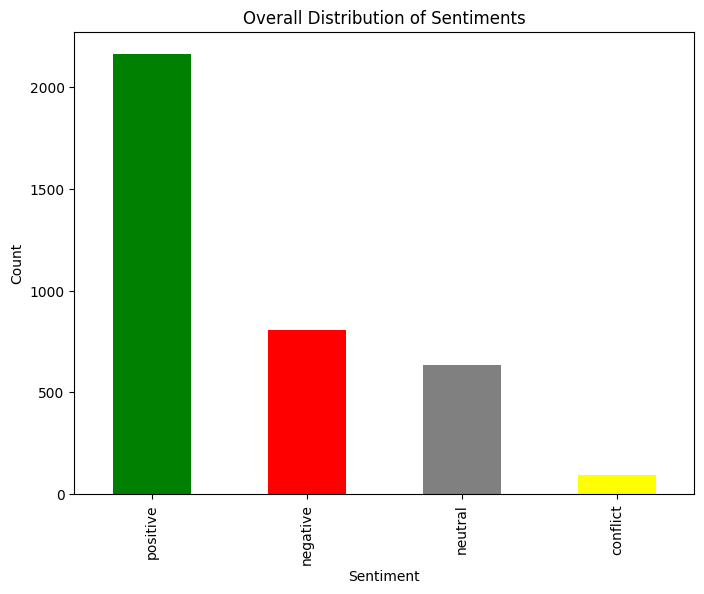

In [63]:
import matplotlib.pyplot as plt

sentiments_counts = df_aspect_polarity['polarity'].value_counts()

plt.figure(figsize=(8, 6))
sentiments_counts.plot(kind='bar', color=['green','red','gray','yellow'])
plt.title('Overall Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

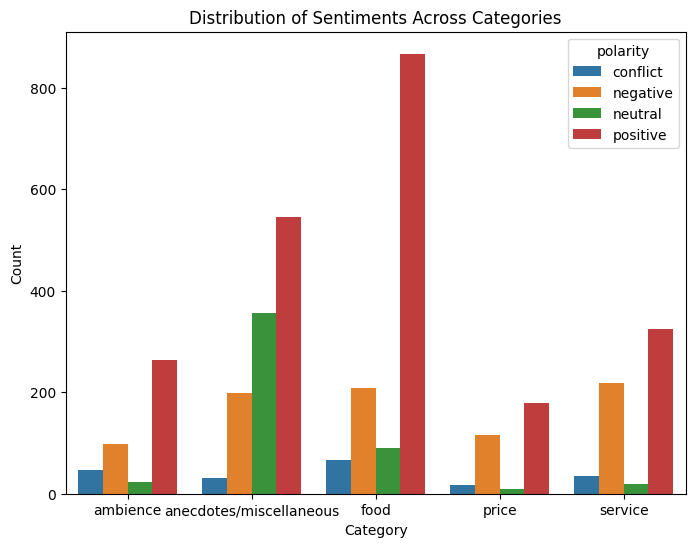

In [66]:
import seaborn as sns

cat_sent = df_cat.groupby(['category','polarity']).size().reset_index(name='count')
plt.figure(figsize=(8, 6))
sns.barplot(x='category', y='count', hue='polarity', data=cat_sent)
plt.title('Distribution of Sentiments Across Categories')
plt.xlabel('Category')
plt.ylabel('Count')

Text(50.7222222222222, 0.5, 'Category')

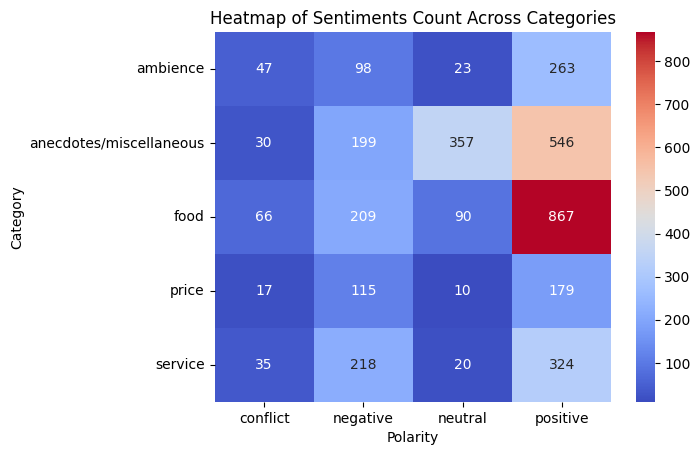

In [70]:
cat_sent = df_cat.groupby(['category','polarity']).size().unstack(fill_value=0)
sns.heatmap(cat_sent, annot = True, cmap='coolwarm', fmt='d')
plt.title('Heatmap of Sentiments Count Across Categories')
plt.xlabel('Polarity')
plt.ylabel('Category')

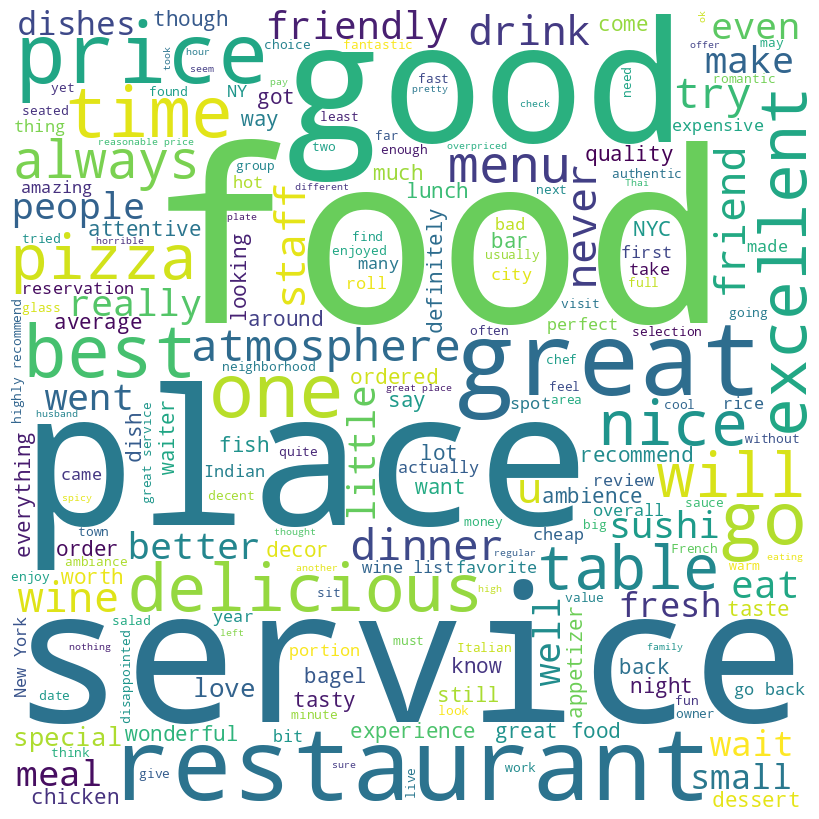

In [71]:

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Combine all text data
all_text = " ".join(df_cat['text'].tolist())

# Generate word cloud
wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      min_font_size = 10).generate(all_text)

# Plot the word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

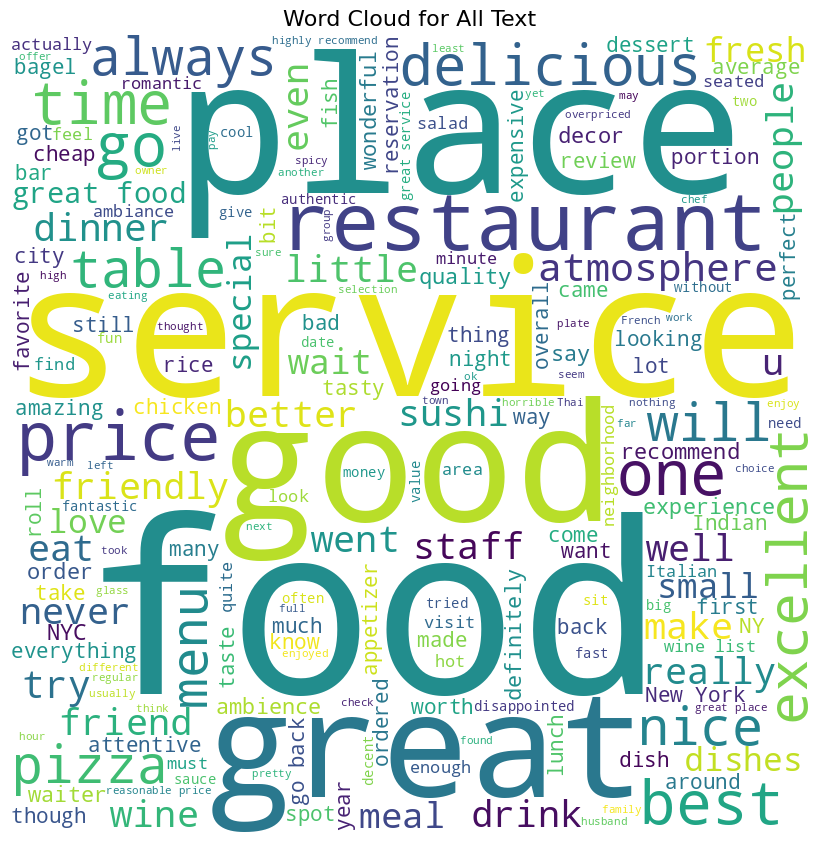

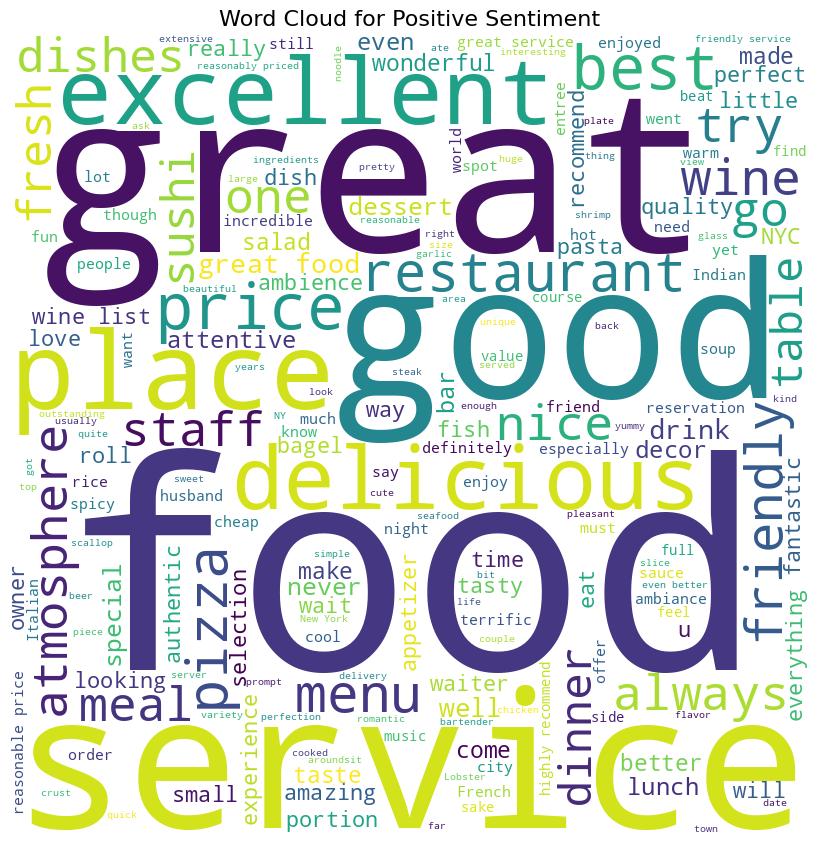

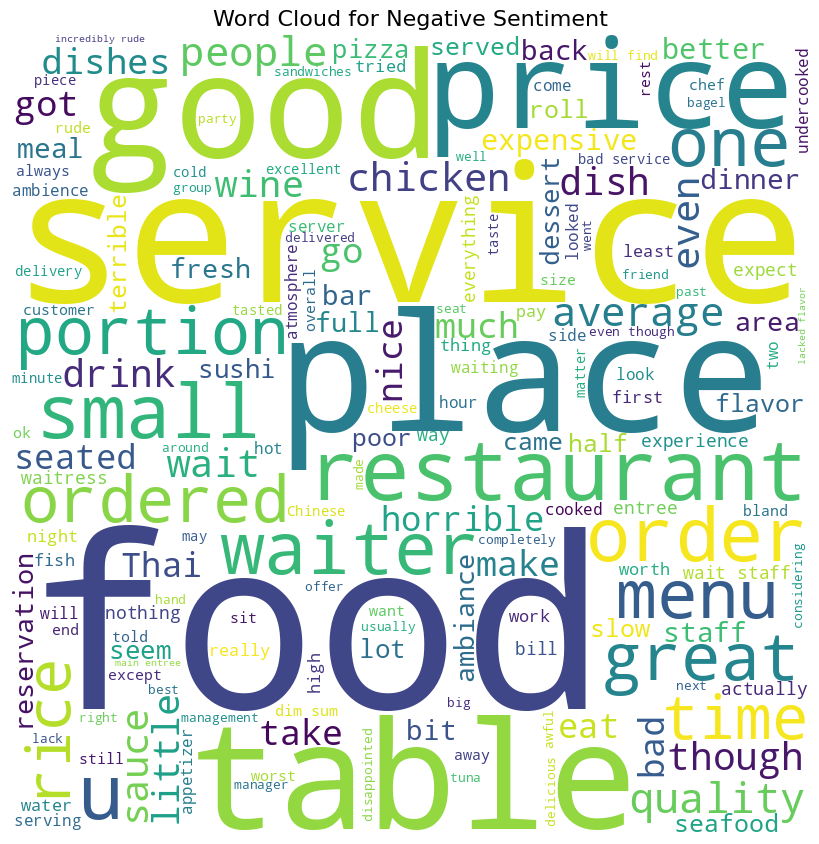

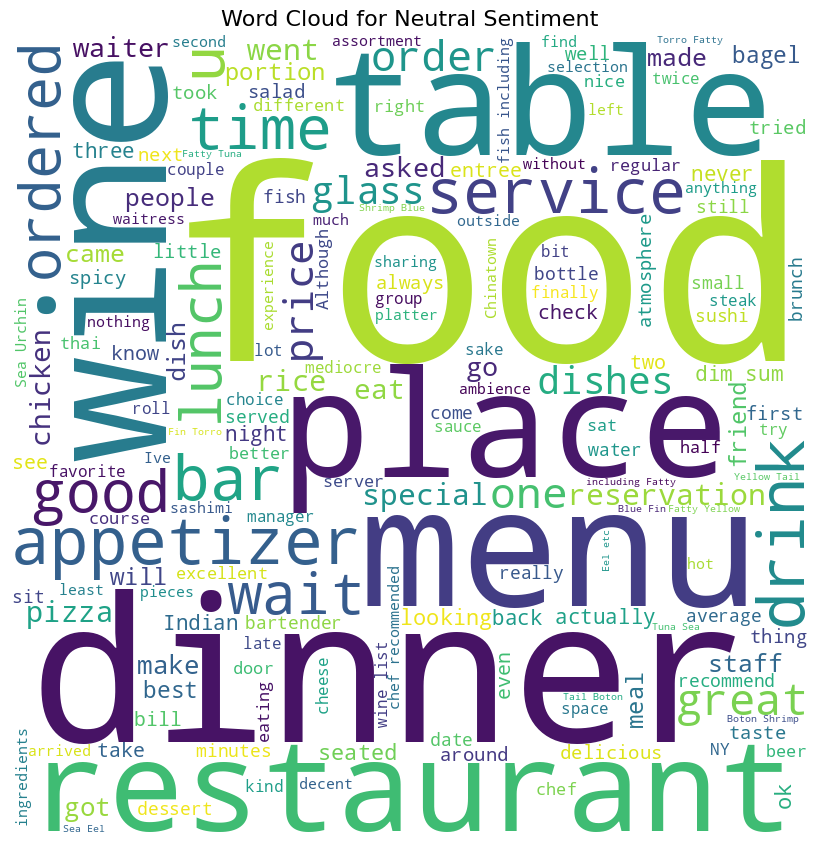

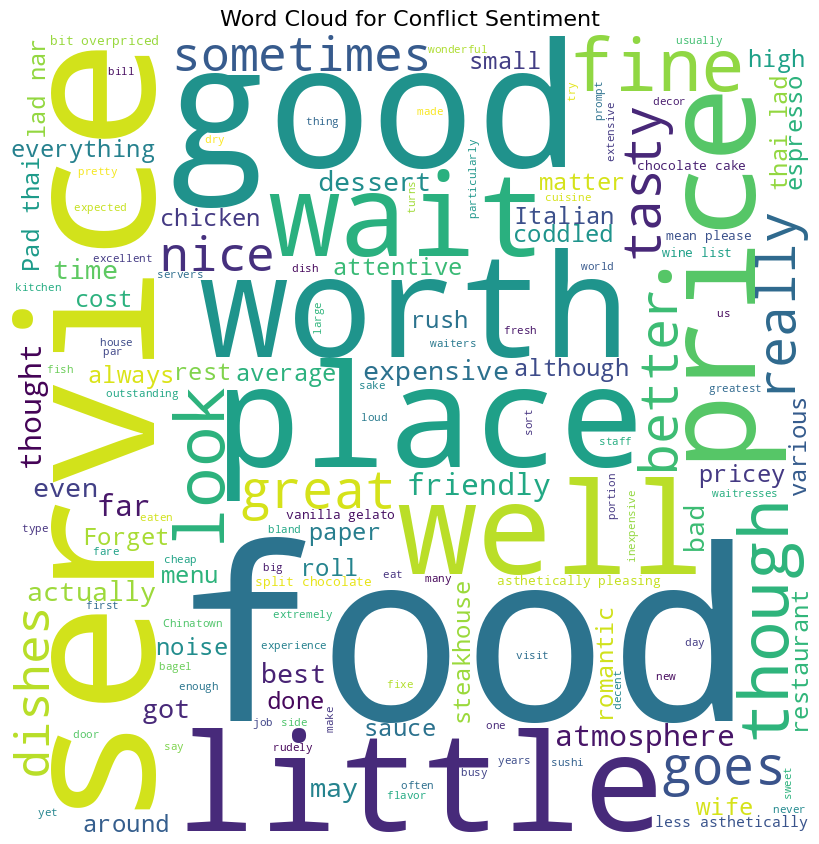

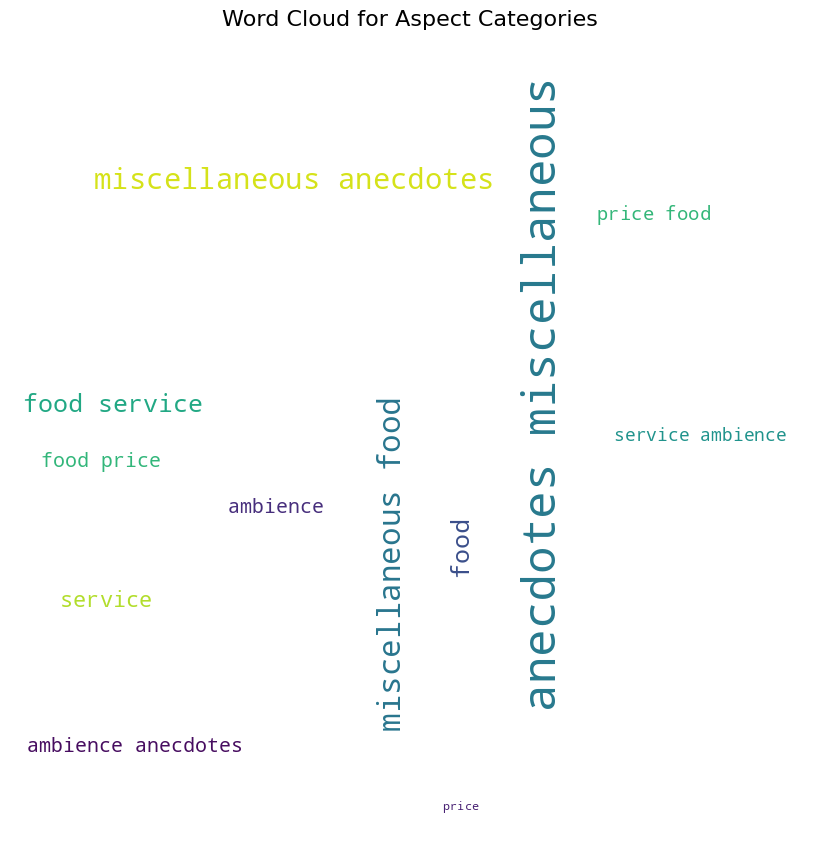

In [72]:
import matplotlib.pyplot as plt

# Function to generate word cloud for a given text
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          min_font_size = 10).generate(text)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title, fontsize=16)
    plt.show()

# Generate word cloud for overall text
all_text = " ".join(df_cat['text'].tolist())
generate_wordcloud(all_text, "Word Cloud for All Text")

# Generate word cloud for sentiments (based on aspect term polarity)
positive_text = " ".join(df_aspect_polarity[df_aspect_polarity['polarity'] == 'positive']['text'].tolist())
negative_text = " ".join(df_aspect_polarity[df_aspect_polarity['polarity'] == 'negative']['text'].tolist())
neutral_text = " ".join(df_aspect_polarity[df_aspect_polarity['polarity'] == 'neutral']['text'].tolist())
conflict_text = " ".join(df_aspect_polarity[df_aspect_polarity['polarity'] == 'conflict']['text'].tolist())

generate_wordcloud(positive_text, "Word Cloud for Positive Sentiment")
generate_wordcloud(negative_text, "Word Cloud for Negative Sentiment")
generate_wordcloud(neutral_text, "Word Cloud for Neutral Sentiment")
generate_wordcloud(conflict_text, "Word Cloud for Conflict Sentiment")


# Generate word cloud for categories
# Combine all category text into a single string, repeating categories based on their count
all_categories = " ".join(df_cat['category'].tolist())
generate_wordcloud(all_categories, "Word Cloud for Aspect Categories")

In [75]:
# end to end test for all three models

import unittest


class TestABSA(unittest.TestCase):

    def test_aspect_term_extraction_model(self):
        """
        Test the aspect term extraction model (BIO Tagging).
        """
        test_text = "The food was amazing and the service was great."
        tokenized_input = tokenizer([test_text], is_split_into_words=True, truncation=True, padding='max_length', max_length=128, return_tensors='pt')

        # Move input to the same device as the model
        tokenized_input = {k: v.to(model.device) for k, v in tokenized_input.items()}

        with torch.no_grad():
            outputs = model(**tokenized_input)
            logits = outputs.logits

        predictions = torch.argmax(logits, dim=2).squeeze().tolist()
        predicted_labels = [id2label[p] for p in predictions if p != -100] # Exclude padding
        print(predicted_labels)
        # Expected labels based on the test text
        # Assuming "food" is an aspect term and "service" is an aspect term
        # This requires careful manual labeling of the test sentence
        # Based on the definition of the BIO tags
        # "The food was amazing and the service was great."
        # The O
        # food B-ASP
        # was O
        # amazing O
        # and O
        # the O
        # service B-ASP
        # was O
        # great O
        # (Padding if any) O, O, ...
        # Note: This is a simplified expectation. Tokenization might split words differently.
        # A more robust test would involve creating a small test dataset with known gold labels.

        # Let's simplify the check to see if the predicted labels are within the expected set of labels
        self.assertTrue(all(label in label_lst for label in predicted_labels))

        # A more specific test would check for the presence of B-ASP and I-ASP tags for expected aspect terms
        # Example: check if 'B-ASP' is present and potentially followed by 'I-ASP'
        self.assertTrue('B-ASP' in predicted_labels)


    def test_aspect_category_classification_model(self):
        """
        Test the aspect category classification model.
        """
        test_text = "The ambiance is lovely."
        test_category = "ambience" # Expected category
        input_text = f"{test_text} [CATEGORY] {test_category}"
        input_encoded = cat_tokenizer([input_text], return_tensors='pt', truncation=True, padding=True)

        # Move input to the same device as the model
        input_encoded = {k: v.to(model_cat.device) for k, v in input_encoded.items()}

        with torch.no_grad():
            outputs = model_cat(**input_encoded)
            logits = outputs.logits

        predicted_label_id = torch.argmax(logits, dim=1).item()
        predicted_category = category_id2label[predicted_label_id]

        # Check if the predicted category is the expected one
        self.assertEqual(predicted_category, test_category)

        # Test with a different category
        test_text_food = "The pasta was delicious."
        test_category_food = "food"
        input_text_food = f"{test_text_food} [CATEGORY] {test_category_food}"
        input_encoded_food = cat_tokenizer([input_text_food], return_tensors='pt', truncation=True, padding=True)
        input_encoded_food = {k: v.to(model_cat.device) for k, v in input_encoded_food.items()}

        with torch.no_grad():
            outputs_food = model_cat(**input_encoded_food)
            logits_food = outputs_food.logits

        predicted_label_id_food = torch.argmax(logits_food, dim=1).item()
        predicted_category_food = category_id2label[predicted_label_id_food]
        print(predicted_category_food)
        self.assertEqual(predicted_category_food, test_category_food)


    def test_aspect_polarity_detection_model(self):
        """
        Test the aspect polarity detection model.
        """
        test_text_positive = "The service was excellent."
        test_aspect_positive = "service"
        expected_polarity_positive = "positive"
        input_text_positive = f"{test_text_positive} [ASP] {test_aspect_positive}"
        input_encoded_positive = pol_tokenizer([input_text_positive], return_tensors='pt', truncation=True, padding=True)
        input_encoded_positive = {k: v.to(pol_model.device) for k, v in input_encoded_positive.items()}

        with torch.no_grad():
            outputs_positive = pol_model(**input_encoded_positive)
            logits_positive = outputs_positive.logits

        predicted_label_id_positive = torch.argmax(logits_positive, dim=1).item()
        predicted_polarity_positive = pol_id2label[predicted_label_id_positive]
        print(predicted_polarity_positive)
        self.assertEqual(predicted_polarity_positive, expected_polarity_positive)

        # Test with negative polarity
        test_text_negative = "The fries were cold."
        test_aspect_negative = "fries"
        expected_polarity_negative = "negative"
        input_text_negative = f"{test_text_negative} [ASP] {test_aspect_negative}"
        input_encoded_negative = pol_tokenizer([input_text_negative], return_tensors='pt', truncation=True, padding=True)
        input_encoded_negative = {k: v.to(pol_model.device) for k, v in input_encoded_negative.items()}

        with torch.no_grad():
            outputs_negative = pol_model(**input_encoded_negative)
            logits_negative = outputs_negative.logits

        predicted_label_id_negative = torch.argmax(logits_negative, dim=1).item()
        predicted_polarity_negative = pol_id2label[predicted_label_id_negative]
        print(predicted_polarity_negative)
        self.assertEqual(predicted_polarity_negative, expected_polarity_negative)

        # Test with neutral polarity
        test_text_neutral = "The restaurant is located downtown."
        test_aspect_neutral = "restaurant" # Or location could be considered an aspect here
        expected_polarity_neutral = "neutral"
        input_text_neutral = f"{test_text_neutral} [ASP] {test_aspect_neutral}"
        input_encoded_neutral = pol_tokenizer([input_text_neutral], return_tensors='pt', truncation=True, padding=True)
        input_encoded_neutral = {k: v.to(pol_model.device) for k, v in input_encoded_neutral.items()}

        with torch.no_grad():
            outputs_neutral = pol_model(**input_encoded_neutral)
            logits_neutral = outputs_neutral.logits

        predicted_label_id_neutral = torch.argmax(logits_neutral, dim=1).item()
        predicted_polarity_neutral = pol_id2label[predicted_label_id_neutral]
        print(predicted_polarity_neutral)
        self.assertEqual(predicted_polarity_neutral, expected_polarity_neutral)


# Run the tests
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


...
----------------------------------------------------------------------
Ran 3 tests in 0.182s

OK


food
positive
negative
neutral
['O', 'O', 'B-ASP', 'O', 'O', 'O', 'O', 'B-ASP', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ASP', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ASP', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ASP', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ASP', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ASP', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ASP', 'O', 'O', 'O', 'O', 'O', 'B-ASP', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ASP', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
